# Regressão Linear

Implementação da previsão do consumo de cimento nos estados  do Brasil utilizando o modelo de Regressão Linear

> Dados utilizados disponíveis em: `https://github.com/LeiteJu/TCC/blob/main/dados/input/df.csv`

Modelo:
- Treinamento: dados de 01/2003 até 06/2017
- Teste: dados de 07/2017 até 12/2019

Experimentos:
- sem normalização de dados
- standard scaler
- minmax scaler
- power transformer
- retirar variáveis de alta correlação
- treinar com dados mais recentes apenas (remover alguns anos)

Melhores resultados: 

|      | Regressão Linear |
|------|------------------|
| RMSE | 38970.7          |
| MAE  | 26435.7          |
| MAPE | 0.32             |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette("Set2")

# Constantes

In [3]:
# path dos dados 
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

#siglas dos estados
SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

# categorias
LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

# regioes 
N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}

# Funções

In [4]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "rmse": RMSE,
        "mae": MAE,
        "mape": MAPE,
    }

    return scores

# mostra as metricas de regressao 
def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['rmse']}")
    print (f"MAE: {scores['mae']}")
    print (f"MAPE: {scores['mape']}")

In [5]:
# classifica o input de acordo com a categoria 
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [6]:
# mostra os deltas percentuais 
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(30,10))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()
    
    return error

In [7]:
# separa y_test e y_pred em dados por estado e ao longo do tempo
def get_pred (y_test, y_pred):
    
    # os testes sao realizados com dados de 07/2017 ate 12/2019
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    # todas as datas se repetem para cada estado
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    # todos os estados se repetem para cada data
    pred['estados'] = SIGLAS * 30
    
    # garante que todos os estados estao presentes em todas as datas 
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(lambda x: REGIOES[x])
    
    return pred

In [8]:
def get_regiao (x):
    return REGIOES[x]

# Seed

In [9]:
def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    
SEED = 41

set_seeds(SEED)

# Dados

In [10]:
def load_data():
    
    df = pd.read_csv(f"{PATH}df.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Sem normalização

In [28]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr_sn = LinearRegression()

regr_sn.fit(x_train, y_train)

print(f"Score: {regr_sn.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr_sn.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9042171956961467
Scores obtidos:
RMSE: 55391.14904561992
MAE: 35148.64226804561
MAPE: 0.6043040236337529


# Standard Scaler

In [30]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr_ss = LinearRegression()

regr_ss.fit(x_train, y_train)

print(f"Score: {regr_ss.score(x_test, y_test)}")

# fazendo previsão 
y_pred_ss = regr_ss.predict(x_test)

scores = score_regression_metrics(y_test, y_pred_ss)
show_scores(scores)

Score: 0.9042171951049084
Scores obtidos:
RMSE: 55391.14921657633
MAE: 35148.642315725585
MAPE: 0.604304023275496


In [29]:
y_pred

array([427060.65565928,  75766.89414086,  90531.65082604, 147519.29523822,
        78038.80375042, 164453.3416295 ,  86785.23851064, 286174.68883018,
       114150.84150259,  82420.428603  ,  33307.36987521,  36027.34465765,
       222720.86287164, 229057.21490766,  58791.0302866 , 765082.71126853,
        50113.76411311,  21435.22806451,  45231.50400422,  62297.05455055,
        31703.17532253, 247201.05145555, 164861.78313481,  68979.68285417,
        90628.49642424, 215279.55426704, 113420.97349438, 434355.19077048,
        83673.46904509,  97659.07487864, 154575.84348817,  85783.9651255 ,
       172783.25290985,  95748.36487713, 294105.30136187, 121840.73260979,
        90101.52813847,  39706.73488934,  40064.11109456, 225917.36934395,
       232902.87702035,  62443.62885646, 769296.33069443,  54204.5935773 ,
        25222.94320135,  49671.13156631,  66412.86237572,  34899.60356961,
       250487.83560672, 168269.30983563,  70269.11606274,  91941.93468979,
       216834.96539378, 1

In [31]:
y_pred_ss

array([427060.65542975,  75766.89413679,  90531.65078424, 147519.29510473,
        78038.80370641, 164453.34155812,  86785.23844924, 286174.68867202,
       114150.84121519,  82420.42855512,  33307.36986037,  36027.34464075,
       222720.86269275, 229057.21482724,  58791.0302446 , 765082.71023812,
        50113.76406383,  21435.22809514,  45231.50395129,  62297.05452742,
        31703.17530487, 247201.05131647, 164861.78309719,  68979.68280518,
        90628.49638182, 215279.55416062, 113420.97345143, 434355.19054083,
        83673.46904104,  97659.07483722, 154575.84335454,  85783.96508378,
       172783.25284153,  95748.36481573, 294105.30120529, 121840.73232238,
        90101.52809042,  39706.73487436,  40064.11107695, 225917.36916669,
       232902.87694108,  62443.62881383, 769296.32966395,  54204.59352731,
        25222.94323407,  49671.13151538,  66412.86235455,  34899.60355396,
       250487.83546948, 168269.30980104,  70269.11601355,  91941.93464895,
       216834.96528897, 1

# MinMax Scaler

In [26]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9042171951049084
Scores obtidos:
RMSE: 55391.149216576334
MAE: 35148.64231572586
MAPE: 0.6043040232755041


# Power Transformer

In [17]:
x,y = load_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

# calcula media e desvio padrao do treino e normaliza os dados
scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.8579867366398657
Scores obtidos:
RMSE: 67446.75410538058
MAE: 49073.620748753994
MAPE: 1.055163879940907


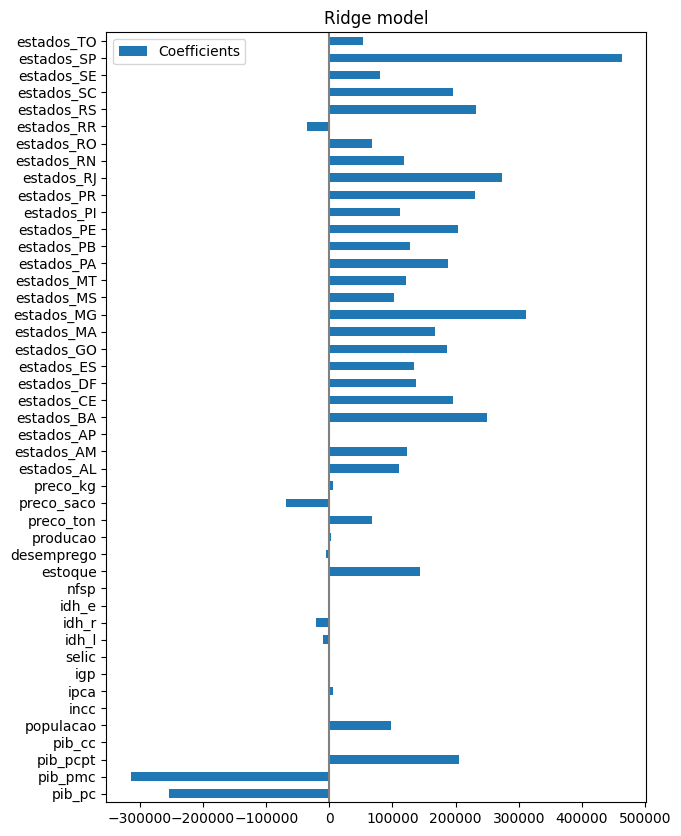

In [18]:
coefs = pd.DataFrame(
   regr.coef_,
   columns=['Coefficients'], index=x.columns
)

coefs.plot(kind='barh', figsize=(9, 10))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Dropando variáveis com alta correlação

In [85]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'nfsp','preco_saco', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9525886520535334
Scores obtidos:
RMSE: 38970.65917062515
MAE: 26435.65453576784
MAPE: 0.3237008399620483


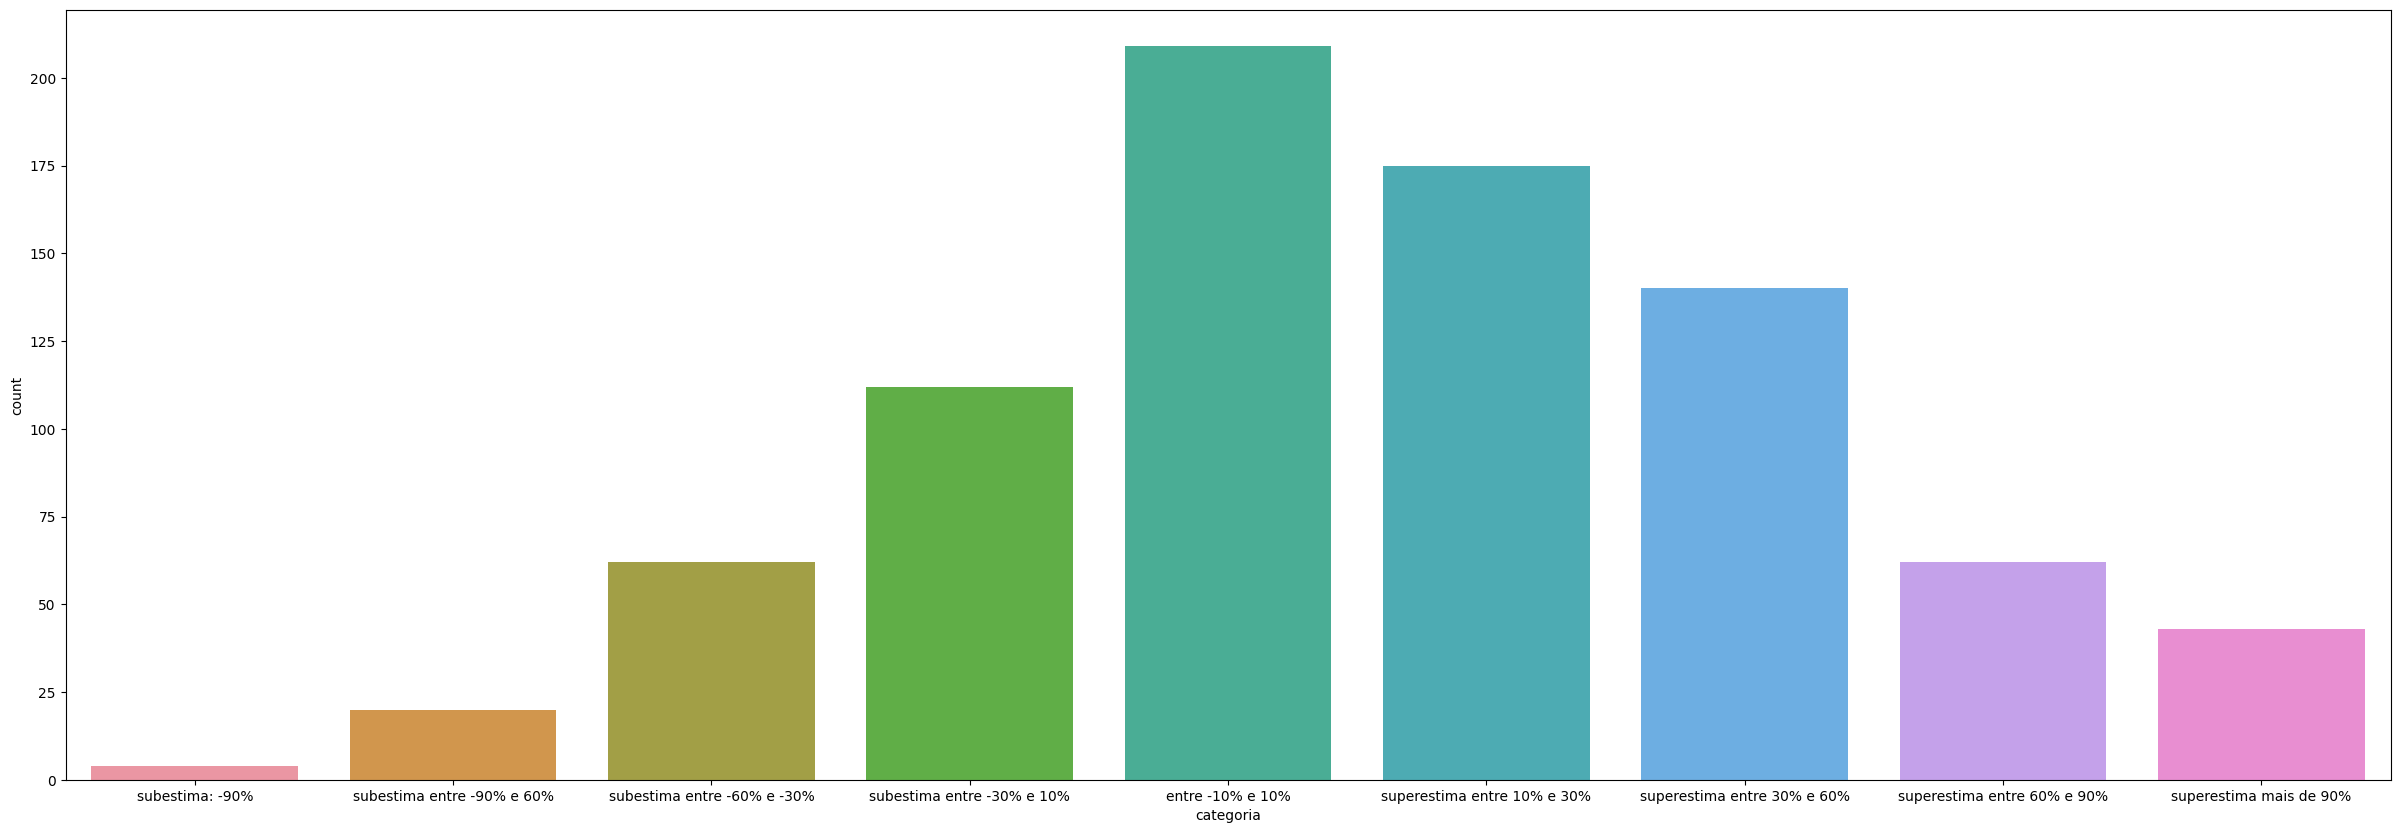

In [87]:
err = show_delta(np.array(y_test), y_pred.flatten())

In [88]:
err['categoria'].value_counts()

entre -10% e 10%               209
superestima entre 10% e 30%    175
superestima entre 30% e 60%    140
subestima entre -30% e 10%     112
subestima entre -60% e -30%     62
superestima entre 60% e 90%     62
superestima mais de 90%         43
subestima entre -90% e 60%      20
subestima: -90%                  4
Name: categoria, dtype: int64

In [89]:
pred=get_pred(y_test, y_pred)

## Gráficos

In [90]:
df = pd.read_csv(f"{PATH}df.csv")

In [91]:
df=df.set_index('data')

In [92]:
df=df[["estados", "consumo"]]

In [93]:
df.head()

,estados,consumo
data,,
2003-01-01,AC,3260.0
2003-02-01,AC,2191.0
2003-03-01,AC,2154.0
2003-04-01,AC,2643.0
2003-05-01,AC,2546.0


In [94]:
pred.tail()

,estados,y_test,y_pred,regiao
data,,,,
2019-12-01,RS,223214.0,213744.049156,SUL
2019-12-01,SC,226233.0,230881.573727,SUL
2019-12-01,SE,39732.0,17939.917762,NORDESTE
2019-12-01,SP,692232.0,876988.516369,SUDESTE
2019-12-01,TO,28749.0,59503.617832,NORTE


In [95]:
pred = pred.reset_index()
df = df.reset_index()

In [96]:
df['data'] = pd.to_datetime(df['data'])
pred['data'] = pd.to_datetime(pred['data'])

In [97]:
resultados=pd.merge(df,pred[["data","y_pred","estados"]].sort_values(["data",'estados']), on=["data", "estados"], how="left")

In [98]:
resultados=resultados.set_index('data')

In [99]:
resultados.to_csv("reg_lin.csv", sep=";", decimal=',')

In [100]:
resultados = resultados.rename({'y_pred':'previsão', 'consumo':"dado real"}, axis=1)

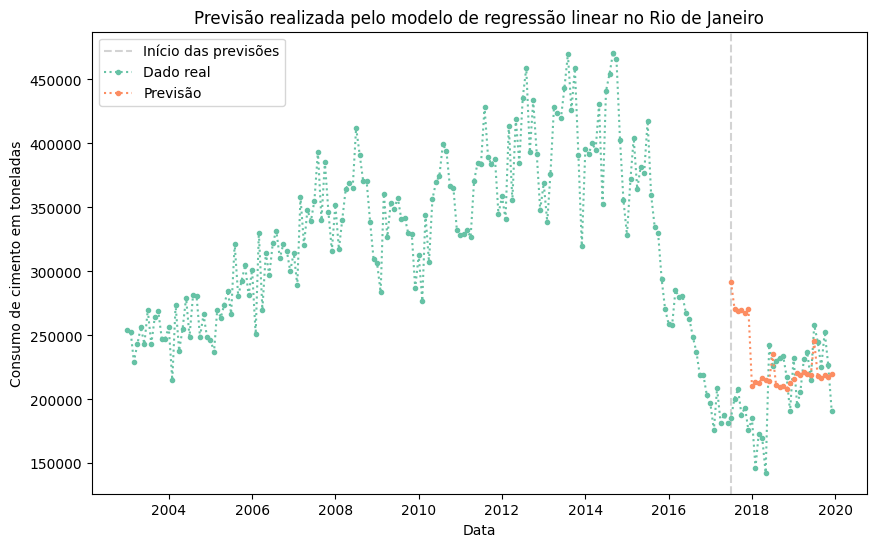

In [137]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Rio de Janeiro")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "RJ"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "RJ"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


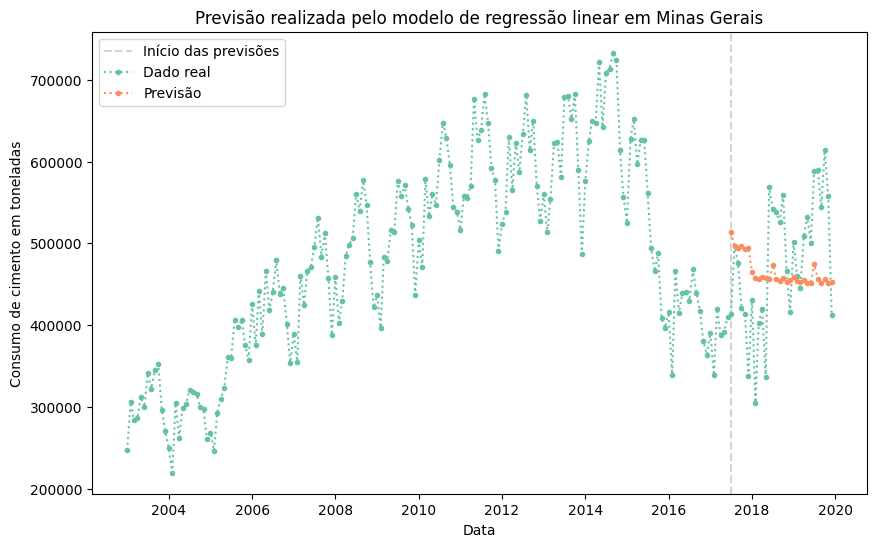

In [136]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em Minas Gerais")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "MG"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "MG"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


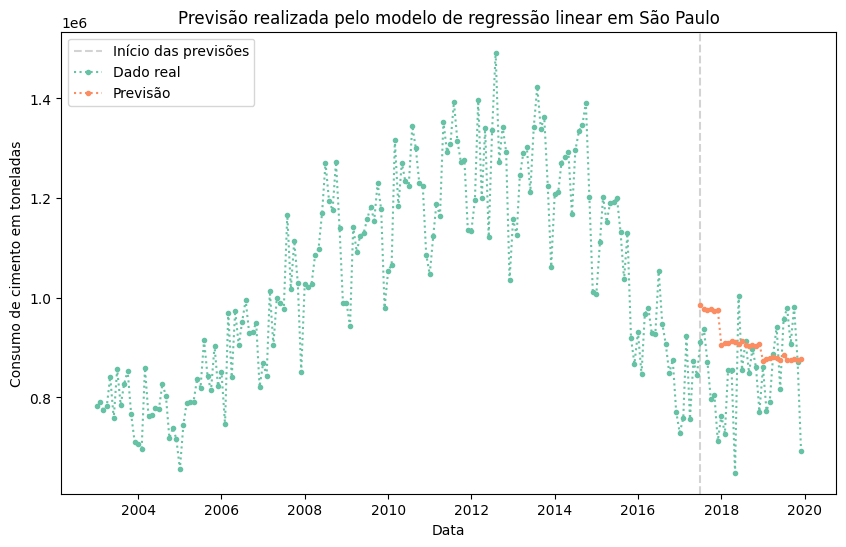

In [103]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


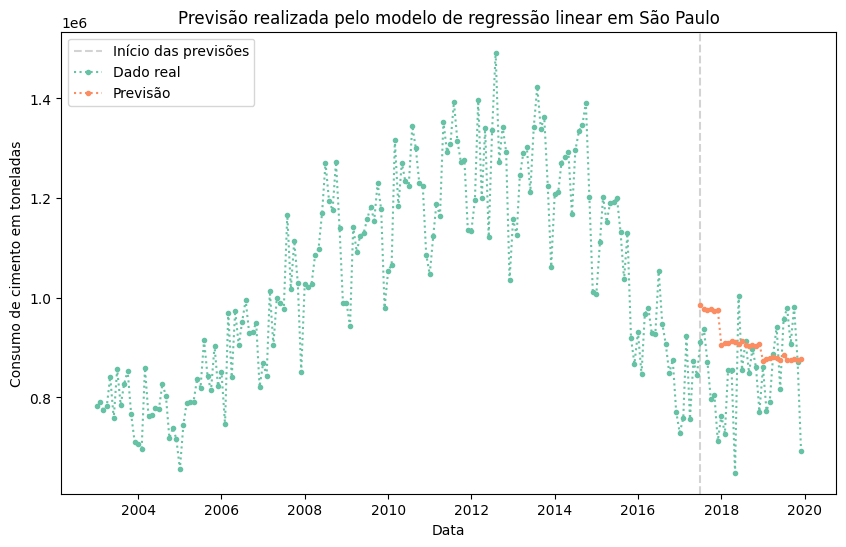

In [104]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear em São Paulo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "SP"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "SP"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


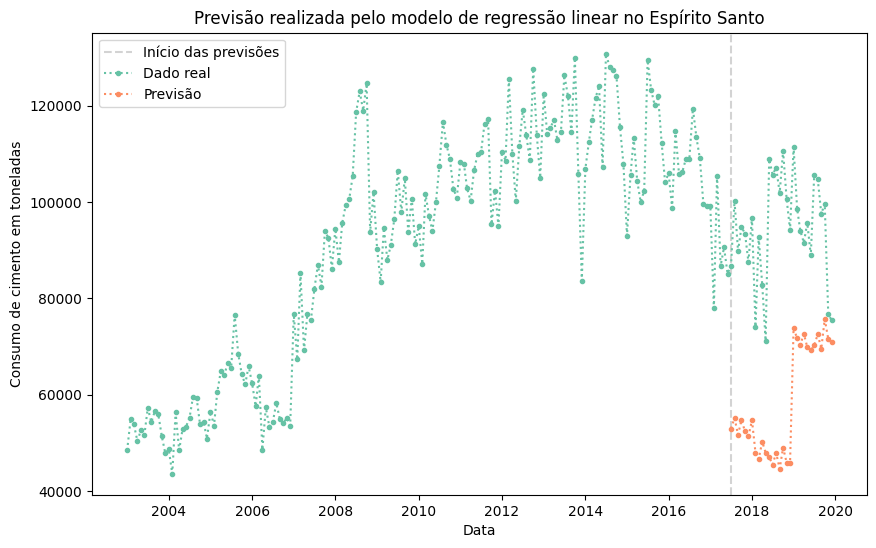

In [105]:
plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear no Espírito Santo")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

plt.plot(resultados[resultados['estados'] == "ES"]['dado real'], linestyle=":", marker=".", label="Dado real")
plt.plot(resultados[resultados['estados'] == "ES"]['previsão'], linestyle=":", marker=".", label="Previsão")

plt.xlabel("Data")
plt.ylabel("Consumo de cimento em toneladas")

plt.legend()

plt.show()


In [62]:
for s in ["SP", "MG","RJ","ES"]:
    print(f'MAPE no estado {s}: {(abs(resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["dado real"] - resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["previsão"]) / resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["dado real"]).mean():.5f}')
    
print (f'MAPE geral: {(abs(resultados[resultados.index >= "2017-07-01"]["dado real"] - resultados[resultados.index >= "2017-07-01"]["previsão"]) / resultados[resultados.index >= "2017-07-01"]["dado real"]).mean():.5f}')

MAPE no estado SP: 0.11628
MAPE no estado MG: 0.16032
MAPE no estado RJ: 0.18957
MAPE no estado ES: 0.37551
MAPE geral: 0.32518


In [108]:
for s in ["SP", "MG","RJ","ES"]:
    print(f'MAPE no estado {s}: {(abs(resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["dado real"] - resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["previsão"])).mean():.5f} -> {resultados[(resultados.index >= "2017-07-01") & (resultados["estados"] == s)]["dado real"].mean()}')
    
print (f'MAPE geral: {(abs(resultados[resultados.index >= "2017-07-01"]["dado real"] - resultados[resultados.index >= "2017-07-01"]["previsão"]) / resultados[resultados.index >= "2017-07-01"]["dado real"]).mean():.5f}')

MAPE no estado SP: 92079.56275 -> 849755.5333333333
MAPE no estado MG: 73498.64699 -> 477549.1666666667
MAPE no estado RJ: 35940.77543 -> 208634.53333333333
MAPE no estado ES: 36302.17178 -> 94624.03333333334
MAPE geral: 0.32518


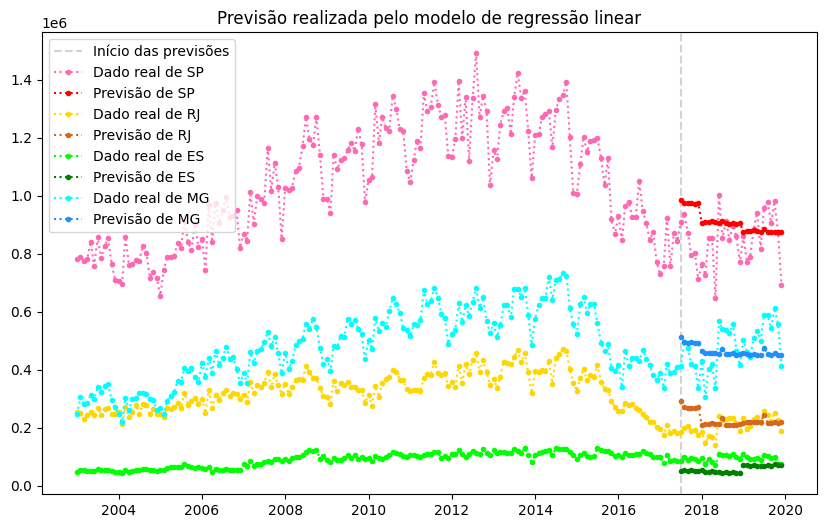

In [135]:
sns.set_palette("Set2")

plt.figure(figsize=(10,6))

plt.title("Previsão realizada pelo modelo de regressão linear")

plt.axvline(x=pd.to_datetime("2017-07-01"), color='lightgray', linestyle="--", label="Início das previsões")

palettes = ["hotpink","r", 
            "gold", "chocolate", 
            "lime", "green", 
            "cyan", "dodgerblue"]
ind = 0

for s in ["SP","RJ","ES","MG"]:
    
    plt.plot(resultados[resultados['estados'] == s]['dado real'], label=f"Dado real de {s}", color=palettes[ind], linestyle=":", marker=".")
    ind += 1
    plt.plot(resultados[resultados['estados'] == s]['previsão'],label=f"Previsão de {s}", color = palettes[ind], linestyle=":", marker=".")
    ind += 1

plt.legend()

plt.show()

<Figure size 1000x600 with 0 Axes>

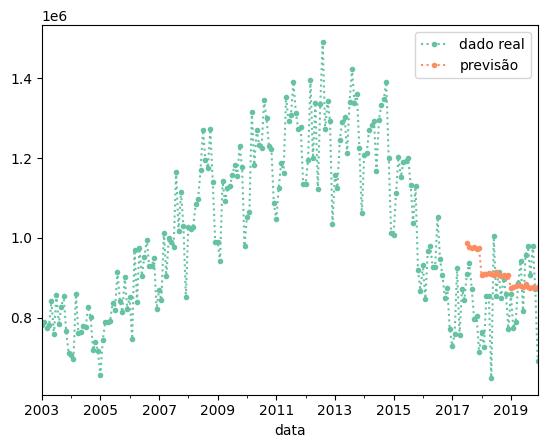

In [69]:
plt.figure(figsize=(10,6))

resultados[resultados['estados'] == "SP"][['dado real','previsão']].plot(linestyle=":", marker=".")

plt.show()

# Teste com dados só a partir de 2009

In [71]:
x,y = load_data()
DROP=['pib_pc', 'incc','igp', 'selic', 'idh_e', 'idh_l', 'nfsp','preco_saco', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)
x = x.iloc[6*27*12:]
y = y.iloc[6*27*12:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.895967537850812
Scores obtidos:
RMSE: 59210.91355685945
MAE: 33672.04041893847
MAPE: 0.27627773641885534


In [67]:
x,y = load_data()
x = x.iloc[6*27*12:]
y = y.iloc[6*27*12:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

regr = LinearRegression()

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Score: 0.9085679739417918
Scores obtidos:
RMSE: 55509.39513162348
MAE: 32442.266811000773
MAPE: 0.3738210491457444


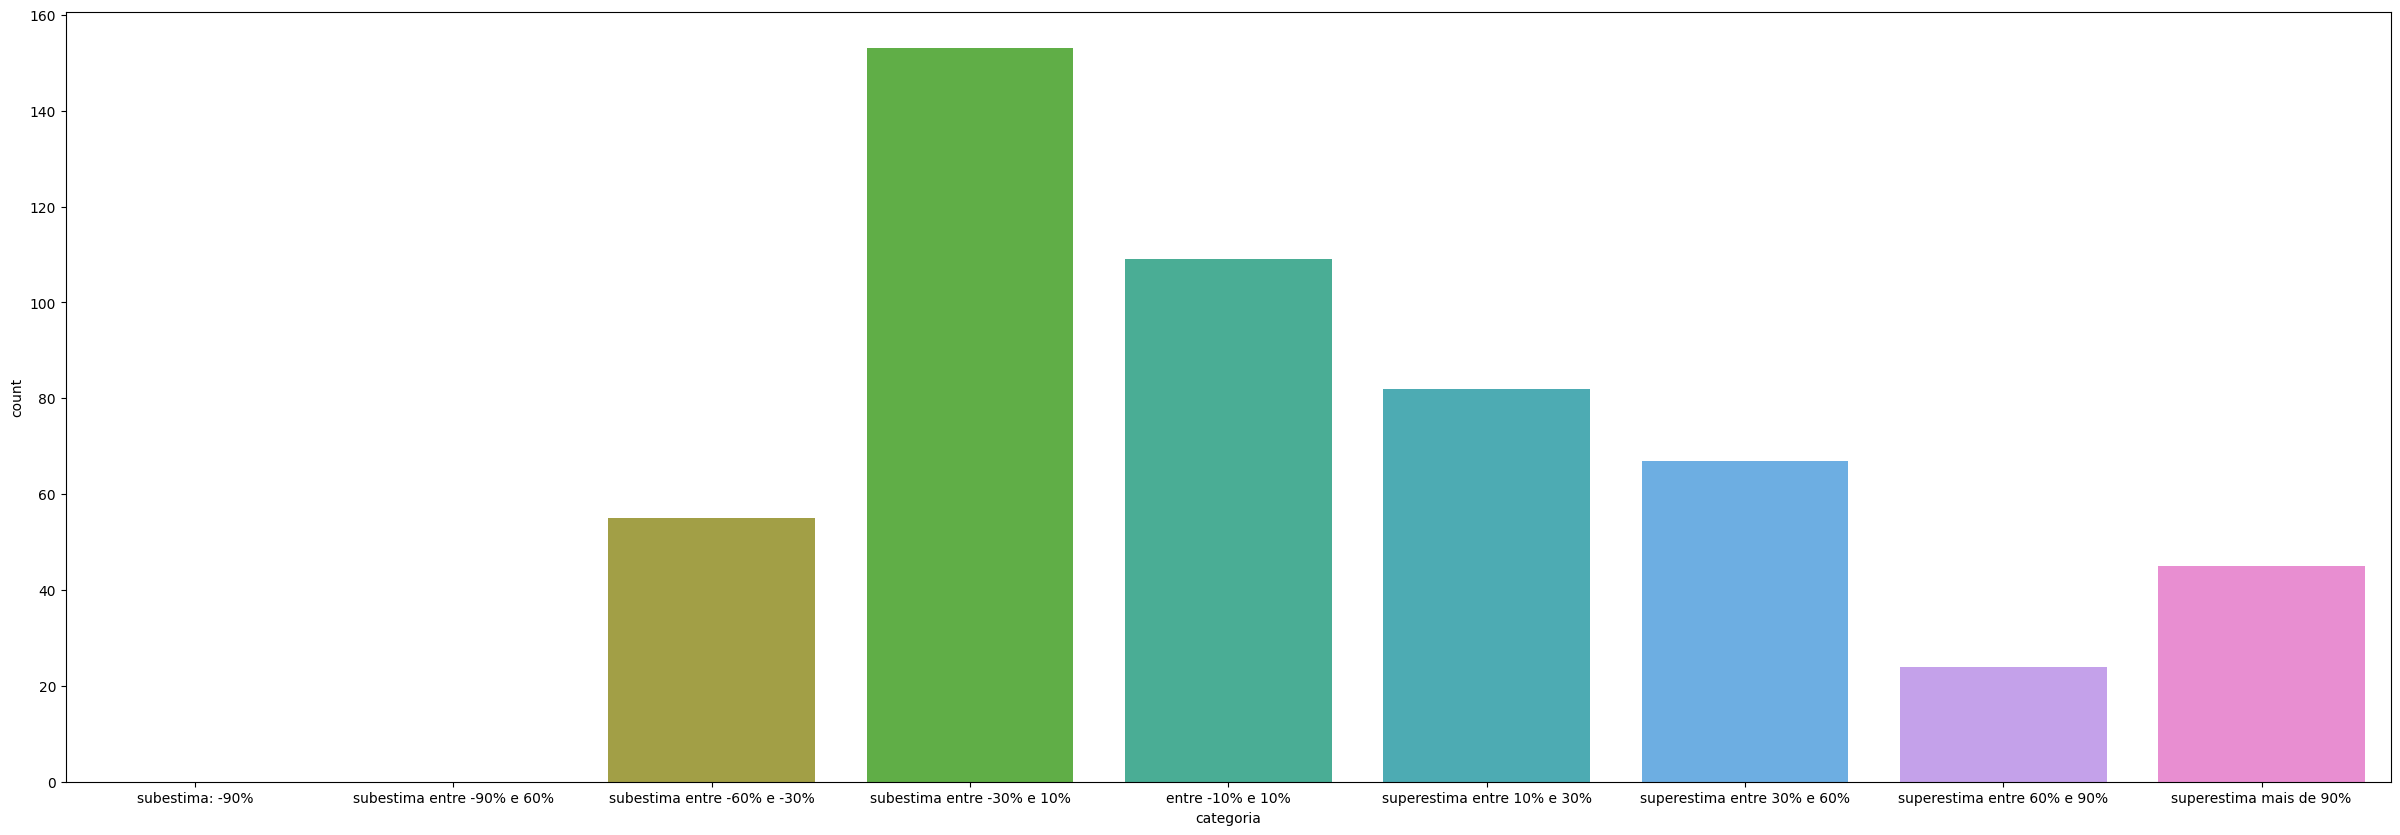

,erro,categoria
0,0.287286,superestima entre 10% e 30%
1,0.084495,entre -10% e 10%
2,-0.033354,entre -10% e 10%
3,0.239698,superestima entre 10% e 30%
4,0.830379,superestima entre 60% e 90%
...,...,...
530,-0.091351,entre -10% e 10%
531,-0.061295,entre -10% e 10%
532,-0.047173,entre -10% e 10%
533,-0.033832,entre -10% e 10%


In [68]:
show_delta(np.array(y_test), y_pred.flatten())